In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.pyplot as plt
import platform
from sklearn.semi_supervised import LabelPropagation
from sklearn.tree import DecisionTreeClassifier

In [15]:
img_path = 'working_dataset'
images = []
labels = []

label_map = {
    'bar': 0,
    'beach': 1,
    'bookstore': 2,
    'restaurant': 3,
    'subway': 4
}

transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

In [16]:
device = torch.device('cpu')
for name, num in label_map.items():
    for img_name in os.listdir(os.path.join(img_path, name)):
        img_file = Image.open(os.path.join(img_path, name, img_name)).convert('RGB')
        img = transforms(img_file).to(device)
        images.append(img.cpu().numpy())
        labels.append(num)
    print(f"finish to read all {name} images")

finish to read all bar images
finish to read all beach images
finish to read all bookstore images
finish to read all restaurant images
finish to read all subway images


In [17]:
X = np.array(images)
Y = np.array(labels)
# Normalize the data
X = X / 255.0

# Reshape
X_reshape = X.reshape(X.shape[0], -1)

In [18]:
num_cluster = 5
#train and test data split
X_train, X_test, Y_train, Y_test = train_test_split(X_reshape,Y, test_size=0.2, random_state=42)

In [36]:
#Labeled and unlabeled data split:
X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(X_train, Y_train, test_size=0.8, random_state=42)
Y_train_unlabeled = np.full(Y_unlabeled.shape, -1)

In [46]:
X_labeled_train = X_labeled
X_unlabeled_train = X_unlabeled
Y_unlabeled_train = Y_train_unlabeled
Y_labeled_train = Y_labeled

#initialise the model:
decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=20, min_samples_split=20, min_samples_leaf=8)


## loop to train the model using updated labeled set:
for i in range(0,15):
    lprediction = decision_tree.fit(X_labeled_train, Y_labeled_train)
    
    Y_unlabeled_pred_proba = lprediction.predict_proba(X_unlabeled_train)
    Y_unlabeled_pred = lprediction.predict(X_unlabeled_train)

    # Filter the high-confidence predictions
    confidence_scores = np.max(Y_unlabeled_pred_proba, axis=1)
    num_high_confidence = int(0.10 * len(Y_unlabeled_pred))
    top_indices = np.argsort(confidence_scores)[-num_high_confidence:]

    X_high_confidence = X_unlabeled_train[top_indices]
    Y_high_confidence = Y_unlabeled_pred[top_indices]

    # Remove the selected high-confidence entries from the unlabeled set
    mask = np.ones(len(X_unlabeled_train), dtype=bool)
    mask[top_indices] = False
    X_unlabeled_train = X_unlabeled_train[mask]
    Y_unlabeled_train = Y_unlabeled_train[mask]

    X_labeled_train = np.concatenate((X_labeled_train, X_high_confidence))
    Y_labeled_train = np.concatenate((Y_labeled_train, Y_high_confidence))

<!-- criterion="entropy", max_depth=20, min_samples_split=20, min_samples_leaf=5
Accuracy: 0.4169435215946844; Precision: 0.3884739528535385; Recall: 0.40028528903329635; F1: 0.3840067450452894
criterion="entropy", max_depth=12, min_samples_split=20, min_samples_leaf=8)
Accuracy: 0.420265780730897; Precision: 0.38787279550448195; Recall: 0.40167441130443554; F1: 0.3826640299327732 -->

Accuracy: 0.3853820598006645; Precision: 0.37759268569804993; Recall: 0.3780437354548741; F1: 0.36574082850129513


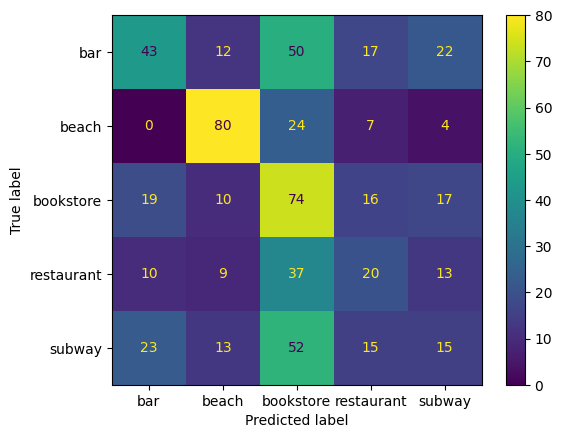

In [47]:
# Evaluation
Y_pred = decision_tree.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')
f1 = f1_score(Y_test, Y_pred, average='macro')
conf_matrix = confusion_matrix(Y_test, Y_pred)
print(f"Accuracy: {accuracy}; Precision: {precision}; Recall: {recall}; F1: {f1}")
confusion_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_map.keys())
confusion_matrix_display.plot()
plt.show()